In [1]:
# KM - Run cell before starting workspace - loads necessary packages
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
install.packages("kknn")
#install.packages("rgl")
#library(rgl)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.3
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
# KM - upload and read the data file from raw github hosted source
#We half the dataframe because we had a really large dataset that R couldn't handle properly
url <- "https://raw.githubusercontent.com/incribo-inc/stroke_prediction/main/stroke_prediction_dataset.csv"
stroke <- read_csv(url)|>
rename_all(~gsub(" ", "_", .))|>
slice(seq(from = 1, to = 14999, by = 2))
stroke

Rows: 15000 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): Patient Name, Gender, Marital Status, Work Type, Residence Type, S...
dbl  (8): Patient ID, Age, Hypertension, Heart Disease, Average Glucose Leve...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Patient_ID,Patient_Name,Age,Gender,Hypertension,Heart_Disease,Marital_Status,Work_Type,Residence_Type,Average_Glucose_Level,⋯,Alcohol_Intake,Physical_Activity,Stroke_History,Family_History_of_Stroke,Dietary_Habits,Stress_Levels,Blood_Pressure_Levels,Cholesterol_Levels,Symptoms,Diagnosis
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,⋯,Social Drinker,Moderate,0,Yes,Vegan,3.48,140/108,"HDL: 68, LDL: 133","Difficulty Speaking, Headache",Stroke
32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,⋯,Rarely,High,0,Yes,Paleo,7.31,154/97,"HDL: 59, LDL: 95","Seizures, Dizziness",Stroke
48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,⋯,Rarely,Low,0,Yes,Pescatarian,6.84,121/95,"HDL: 65, LDL: 68",Difficulty Speaking,Stroke
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
36750,Anvi Setty,79,Female,0,1,Divorced,Private,Rural,82.69,⋯,Frequent Drinker,Low,1,Yes,Vegetarian,8.69,100/99,"HDL: 60, LDL: 65","Headache, Weakness",No Stroke
87707,Anahita Virk,47,Female,0,0,Married,Private,Urban,107.58,⋯,Never,Low,1,No,Gluten-Free,1.47,155/71,"HDL: 35, LDL: 183",Difficulty Speaking,No Stroke
22343,Anvi Mannan,73,Male,0,0,Single,Self-employed,Urban,169.42,⋯,Never,High,0,Yes,Paleo,1.53,157/74,"HDL: 79, LDL: 91","Severe Fatigue, Numbness, Confusion, Dizziness, Loss of Balance",No Stroke


In [3]:
# set seed - don't change!
set.seed(1234)

# wrangling - selects cols for prediction
stroke_selected <- stroke |>
    select(Age, Gender, Hypertension, Heart_Disease, Alcohol_Intake, 
           Physical_Activity, Family_History_of_Stroke,
           Dietary_Habits, Stress_Levels, Diagnosis)

# rename columns + make diagnosis a factor due to our classification
stroke_renamed <- stroke_selected |>
    rename(age = Age,
           gender = Gender,
           hypertension = Hypertension,
           heart_disease = Heart_Disease,
           alcohol_intake = Alcohol_Intake,
           activity = Physical_Activity,
           family_history = Family_History_of_Stroke,
           diet = Dietary_Habits,
           stress = Stress_Levels,
           diagnosis = Diagnosis) |>
mutate (diagnosis = as_factor (diagnosis))

stroke_renamed$alcohol_intake <- as.numeric(factor(stroke_renamed$alcohol_intake,
                                           levels = c("Never", "Rarely", "Social Drinker", "Frequent Drinker"),
                                           labels = c(0, 1, 2, 3)))

stroke_renamed$family_history <- as.numeric(factor(stroke_renamed$family_history,
                                           levels = c("Yes", "No"),
                                           labels = c(1, 0)))

stroke_renamed$activity <- as.numeric(factor(stroke_renamed$activity,
                                             levels = c("Moderate", "Low", "High"),
                                             labels = c(2, 1, 3)))      

stroke_renamed$gender <- as.numeric(factor(stroke_renamed$gender,
                                           levels = c("Male", "Female"),
                                           labels = c(0, 1)))
stroke_renamed$diet <- as.numeric(factor(stroke_renamed$diet,
                                           levels = c("Vegan", "Paleo", "Pescatarian", "Vegetarian","Non-Vegetarian", "Gluten-Free", "Keto"),
                                           labels = c(1, 2, 3, 4, 5, 6,7)))
stroke_renamed

age,gender,hypertension,heart_disease,alcohol_intake,activity,family_history,diet,stress,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
56,1,0,1,3,1,1,1,3.48,Stroke
26,1,1,1,2,3,1,2,7.31,Stroke
51,1,1,1,2,2,1,3,6.84,Stroke
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
79,2,0,1,4,2,1,4,8.69,No Stroke
47,2,0,0,1,2,2,6,1.47,No Stroke
73,1,0,0,1,3,1,2,1.53,No Stroke


In [4]:
# split data
# we are using 9 predictors, so 2/3 = 67% data used as training, 1/3 = 33% predicting
pre_split_stroke <- stroke

stroke_split <- initial_split(stroke_renamed, prop = 0.67, strata = diagnosis)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)

stroke_train
# stroke_test

age,gender,hypertension,heart_disease,alcohol_intake,activity,family_history,diet,stress,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
41,1,0,1,4,2,1,3,1.56,No Stroke
31,2,1,1,4,3,2,4,3.26,No Stroke
40,2,1,1,3,2,2,4,9.70,No Stroke
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,2,0,1,2,3,1,5,2.95,Stroke
47,2,0,1,3,1,1,1,3.67,Stroke
81,2,1,1,2,1,2,5,5.49,Stroke


# Socioeconomic Demographics KNN Classification:
## Predictors: 
    * Age
    * Gender
    * Family Stroke History

In [5]:
# Create 3D scatter plot using plotly

# Set up colors based on diagnosis
#colors <- ifelse(stroke_renamed$diagnosis == "Stroke", "red", "blue")

# Open 3D plotting device
#rgl.open()

# Create 3D scatter plot
#plot3d(
#  stroke_renamed$age, 
#  stroke_renamed$gender, 
#  stroke_renamed$family_history, 
#  col = colors, 
#  size = 2, 
#  type = "s",
#  xlab = "Age",
#  ylab = "Gender",
#  zlab = "Family History",
#  main = "3D Scatter Plot with Diagnosis"
#)

# Display the plot
#rglwidget()

## 1. First we perform cross-validation to obtain the best K
##### 1.1. Select the desired columns from `stroke_train` and `stroke_test`

In [6]:
#KM First we select only the rows we need for this classification
#1.1
stroke_train_demographics  <- stroke_train |>
select (diagnosis, age, gender, family_history)

stroke_test_demographics  <- stroke_test |>
select (diagnosis, age, gender, family_history)

stroke_train_demographics
stroke_test_demographics

diagnosis,age,gender,family_history
<fct>,<dbl>,<dbl>,<dbl>
No Stroke,41,1,1
No Stroke,31,2,2
No Stroke,40,2,2
⋮,⋮,⋮,⋮
Stroke,35,2,1
Stroke,47,2,1
Stroke,81,2,2


diagnosis,age,gender,family_history
<fct>,<dbl>,<dbl>,<dbl>
Stroke,51,1,1
No Stroke,40,2,2
Stroke,42,1,2
⋮,⋮,⋮,⋮
No Stroke,54,2,1
No Stroke,79,1,2
No Stroke,47,2,2


##### 1.2. Split the `stroke_train_demographics` for cross-validation through `vfold_cv`.
##### 1.3. Create the `recipe`, include the correct `predictors` and `pre-process` the data.
##### 1.4. Create the `knn` `model`, using the appropriate engine and mode and set `neighbors = tune()`.
##### 1.5. Fit the `recipe` and `model` into the `workflow`.

In [7]:
options(repr.plot.height = 5, repr.plot.width = 6)

#1.2
demographics_vfold <- vfold_cv(stroke_train_demographics, strata=diagnosis, v=5)

#1.3
demographics_recipe <- recipe (diagnosis ~ . , data= stroke_train_demographics)
demographics_recipe

#1.4
demographics_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine ("kknn") |>
    set_mode ("classification")
demographics_spec

#1.5
demographics_workflow <- workflow() |>
    add_recipe (demographics_recipe)|>
    add_model (demographics_spec)
demographics_workflow

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


6. Make a `tibble` called `k_vals` to determine the range and intervals of $K$s we want to perform the cross-validation on.
7. Used the `tune_grid` function on our train/validation splits to estimate the classifier accuracy for a range of K values, collected and filtered the `accuracy` to obtain the `accuracies` of our $K$s.
8. Plotted `accuracy` vs. `K` to visualize what would be the best $K$ with the highest accuracy estimate that doesn’t change much if you change K to a nearby value.
##### Notes to keep in mind for this section:
* We have picked the range to be from 40-80 through a series of background work:
* First we used the formula `sqrt(# of rows)/2` to roughly get an idea of what $K$ can be
* The result was 41, we made two ranges: one from 1-40 and one from 41-80 and plotted the `K` vs. `Accuracy` for both
* Obtained graphs showed the range to be used is 41-81 because that range has the maximum $K$ `accuracy`.
* The code for graph of cross validation of 1-40 and 41-59 is removed to avoid wasting memory.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
40,accuracy,binary,0.4924358,5,0.007285620,Preprocessor1_Model01
42,accuracy,binary,0.4968175,5,0.005861273,Preprocessor1_Model02
44,accuracy,binary,0.5002018,5,0.005891627,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
76,accuracy,binary,0.4976096,5,0.003435572,Preprocessor1_Model19
78,accuracy,binary,0.4954227,5,0.006379781,Preprocessor1_Model20
80,accuracy,binary,0.4998014,5,0.007716444,Preprocessor1_Model21


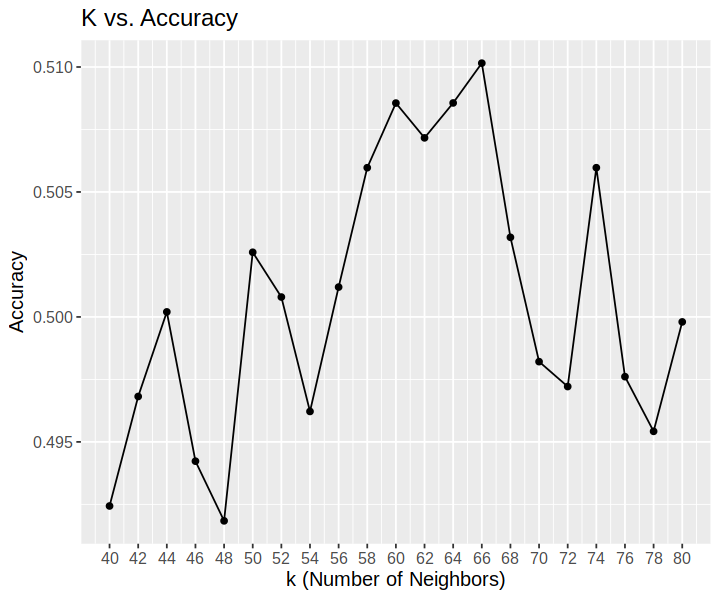

In [8]:
#1.6
k_vals_demographics <- tibble(neighbors = seq(40,80, by=2))
#1.7
accurasies_demographics <- demographics_workflow |>
    tune_grid (resamples = demographics_vfold, grid = k_vals_demographics) |>
    collect_metrics() |>
  filter(.metric == "accuracy")
accurasies_demographics
#1.8
cross_val_plot_demographics <- accurasies_demographics |>
    ggplot(aes (x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs (x = "k (Number of Neighbors)",
          y = "Accuracy",
         title = "K vs. Accuracy") +
      theme(text = element_text(size = 12))+
scale_x_continuous(breaks = seq(40, 80, by = 2)) # adjusting the x-axis
cross_val_plot_demographics

##### 1.9 As shown in the `K`Vs.`accuracy` plot, the best $K$ is $K$=66

## 2. Now that we have obtained our best `K`, we will perform `knn` on our training data with this value of `k`
##### 2.1. Create a new `knn` `model`, using the appropriate engine and mode and set `neighbors = 76` as we obtained in the cross-validation.
##### 2.2. Fit the `recipe` we made previously called`demographics_recipe`and new `model` into the `workflow`.
##### 2.3. Use the function `predict` to apply the prediction on our testing data `stroke_test_demographics`.
##### 2.4. Finally we report the accuracy of this prediction and will store this number to compare to accuracy of our `lifestyle` and `health factors` models.

In [9]:
#2.1 
demographics_final_spec <- nearest_neighbor (weight_func = "rectangular", neighbors = 66)|>
    set_engine("kknn") |>
    set_mode("classification")

#2.2
demographics_final_workflow <- workflow() |>
    add_recipe (demographics_recipe)|>
    add_model (demographics_final_spec)|>
    fit(data= stroke_train_demographics)
demographics_final_workflow

2.3
demographics_prediction <- predict(demographics_final_workflow, stroke_test_demographics)|>
    bind_cols (stroke_test_demographics)
demographics_prediction

2.4
demographics_accuracy <- demographics_prediction |>
  metrics(truth = diagnosis, estimate = .pred_class) |>
  filter(.metric == "accuracy")
demographics_accuracy

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(66,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4460589
Best kernel: rectangular
Best k: 66

[1] 2.3

.pred_class,diagnosis,age,gender,family_history
<fct>,<fct>,<dbl>,<dbl>,<dbl>
Stroke,Stroke,51,1,1
Stroke,No Stroke,40,2,2
No Stroke,Stroke,42,1,2
⋮,⋮,⋮,⋮,⋮
No Stroke,No Stroke,54,2,1
No Stroke,No Stroke,79,1,2
No Stroke,No Stroke,47,2,2


[1] 2.4

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5117124


## Socioeconomic Demographics KNN Classification Accuracy = 0.5117124

# Lifestyle KNN Classification:
## Predictors: 
    * Alcohol Intake
    * Dietary_Habits
    * Physical_Activity

## 1. First we perform cross-validation to obtain the best K
##### 1.1. Select the desired columns from `stroke_train` and `stroke_test`

In [10]:
#KM First we select only the rows we need for this classification
#1.1
stroke_train_lifestyle  <- stroke_train |>
select (diagnosis, alcohol_intake, diet, activity)

stroke_test_lifestyle  <- stroke_test |>
select (diagnosis, alcohol_intake, diet, activity)

stroke_train_lifestyle
stroke_train_lifestyle

diagnosis,alcohol_intake,diet,activity
<fct>,<dbl>,<dbl>,<dbl>
No Stroke,4,3,2
No Stroke,4,4,3
No Stroke,3,4,2
⋮,⋮,⋮,⋮
Stroke,2,5,3
Stroke,3,1,1
Stroke,2,5,1


diagnosis,alcohol_intake,diet,activity
<fct>,<dbl>,<dbl>,<dbl>
No Stroke,4,3,2
No Stroke,4,4,3
No Stroke,3,4,2
⋮,⋮,⋮,⋮
Stroke,2,5,3
Stroke,3,1,1
Stroke,2,5,1


##### 1.2. Split the `stroke_train_lifestyle` for cross-validation through `vfold_cv`.
##### 1.3. Create the `recipe`, include the correct `predictors` and `pre-process` the data.
##### 1.4. Create the `knn` `model`, using the appropriate engine and mode and set `neighbors = tune()`.
##### 1.5. Fit the `recipe` and `model` into the `workflow`.

In [11]:
options(repr.plot.height = 5, repr.plot.width = 6)

#1.2
lifestyle_vfold <- vfold_cv(stroke_train_lifestyle, strata=diagnosis, v=5)

#1.3
lifestyle_recipe <- recipe (diagnosis ~ . , data= stroke_train_lifestyle)
lifestyle_recipe

#1.4
lifestyle_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine ("kknn") |>
    set_mode ("classification")
lifestyle_spec

#1.5
lifestyle_workflow <- workflow() |>
    add_recipe (lifestyle_recipe)|>
    add_model (lifestyle_spec)
lifestyle_workflow

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


##### 1.6. Make a `tibble` called `k_vals` to determine the range and intervals of $K$s we want to perform the cross-validation on.
##### 1.7. Used the `tune_grid` function on our train/validation splits to estimate the classifier accuracy for a range of K values, collected and filtered the `accuracy` to obtain the `accuracies` of our $K$s.
##### 1.8. Plotted `accuracy` vs. `K` to visualize what would be the best $K$ with the highest accuracy estimate that doesn’t change much if you change K to a nearby value.
##### Notes to keep in mind for this section:
* We have picked the range to be from 2-46 through a series of background work:
* First we used the formula `sqrt(# of rows)/2` to roughly get an idea of what $K$ can be
* The result was 41, we made two ranges: one from 1-46 and one from 46-100 and plotted the `K` vs. `Accuracy` for both
* Obtained graphs showed the range to be used is 1-46 because that range has the maximum $K$ `accuracy`.
* The code for graph of cross validation of 46-100 is removed to avoid wasting memory.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.5015924,5,9.989891e-05,Preprocessor1_Model01
4,accuracy,binary,0.5015924,5,9.989891e-05,Preprocessor1_Model02
6,accuracy,binary,0.5015924,5,9.989891e-05,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
42,accuracy,binary,0.4878577,5,0.006181515,Preprocessor1_Model21
44,accuracy,binary,0.4860657,5,0.004991215,Preprocessor1_Model22
46,accuracy,binary,0.4836760,5,0.006014955,Preprocessor1_Model23


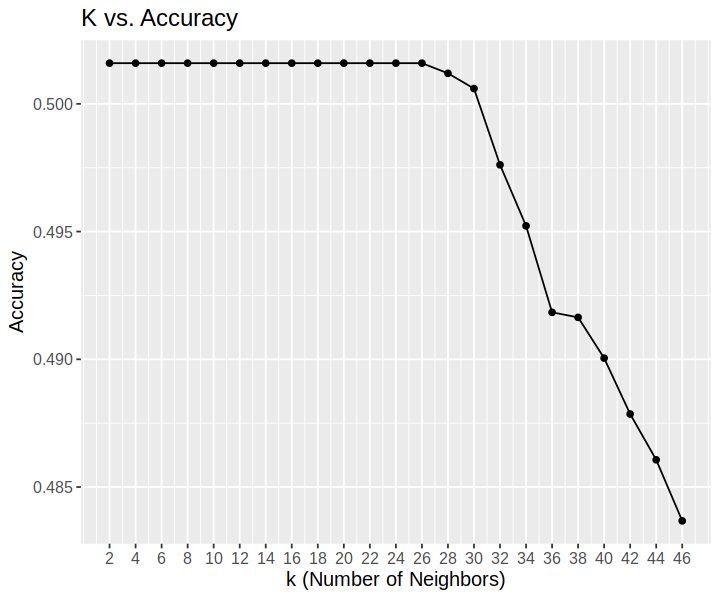

In [12]:
#1.6
k_vals_lifestyle <- tibble(neighbors = seq(2,46, by=2))
#1.7
accurasies_lifestyle <- lifestyle_workflow |>
    tune_grid (resamples = lifestyle_vfold, grid = k_vals_lifestyle) |>
    collect_metrics() |>
  filter(.metric == "accuracy")
accurasies_lifestyle
#1.8
cross_val_plot_lifestyle <- accurasies_lifestyle |>
    ggplot(aes (x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs (x = "k (Number of Neighbors)",
          y = "Accuracy",
         title = "K vs. Accuracy") +
      theme(text = element_text(size = 12))+
scale_x_continuous(breaks = seq(2, 46, by = 2)) # adjusting the x-axis
cross_val_plot_lifestyle

##### 1.9 As shown in the `K`Vs.`accuracy` plot, the best $K$ is $K$=2,4,6,8,10,12,14,16,18,20,22,24,26

## 2. Now that we have obtained our best `K`, we will perform `knn` on our training data with this value of `k`
##### 2.1. Create a new `knn` `model`, using the appropriate engine and mode and set `neighbors = 76` as we obtained in the cross-validation.
##### 2.2. Fit the `recipe` we made previously called`demographics_recipe`and new `model` into the `workflow`.
##### 2.3. Use the function `predict` to apply the prediction on our testing data `stroke_test_demographics`.
##### 2.4. Finally we report the accuracy of this prediction and will store this number to compare to accuracy of our `lifestyle` and `health factors` models.

In [13]:
#2.1 
lifestyle_final_spec <- nearest_neighbor (weight_func = "rectangular", neighbors = 14)|>
    set_engine("kknn") |>
    set_mode("classification")
lifestyle_final_spec

#2.2
lifestyle_final_workflow <- workflow() |>
    add_recipe (lifestyle_recipe)|>
    add_model (lifestyle_final_spec)|>
    fit(data= stroke_train_lifestyle)
lifestyle_final_workflow

2.3
lifestyle_prediction <- predict(lifestyle_final_workflow, stroke_test_lifestyle)|>
    bind_cols (stroke_test_lifestyle)
lifestyle_prediction

2.4
lifestyle_accuracy <- lifestyle_prediction |>
  metrics(truth = diagnosis, estimate = .pred_class) |>
  filter(.metric == "accuracy")
lifestyle_accuracy

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 14
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(14,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4984076
Best kernel: rectangular
Best k: 14

[1] 2.3

.pred_class,diagnosis,alcohol_intake,diet,activity
<fct>,<fct>,<dbl>,<dbl>,<dbl>
No Stroke,Stroke,2,3,2
No Stroke,No Stroke,1,4,2
No Stroke,Stroke,4,2,2
⋮,⋮,⋮,⋮,⋮
No Stroke,No Stroke,2,3,3
No Stroke,No Stroke,3,6,3
No Stroke,No Stroke,1,6,2


[1] 2.4

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5016155


## Lifestyle KNN Classification Accuracy = 0.5016155

# Health KNN Classification:
## Predictors: 
    * Hypertension
    * Heart Disease
    * Stress Levels

## 1. First we perform cross-validation to obtain the best K
##### 1.1. Select the desired columns from `stroke_train` and `stroke_test`

In [14]:
#KM First we select only the rows we need for this classification
#1.1
stroke_train_health  <- stroke_train |>
select (diagnosis, 	hypertension, heart_disease, stress)

stroke_test_health  <- stroke_test |>
select (diagnosis, 	hypertension, heart_disease, stress)

stroke_train_health
stroke_test_health

diagnosis,hypertension,heart_disease,stress
<fct>,<dbl>,<dbl>,<dbl>
No Stroke,0,1,1.56
No Stroke,1,1,3.26
No Stroke,1,1,9.70
⋮,⋮,⋮,⋮
Stroke,0,1,2.95
Stroke,0,1,3.67
Stroke,1,1,5.49


diagnosis,hypertension,heart_disease,stress
<fct>,<dbl>,<dbl>,<dbl>
Stroke,1,1,6.84
No Stroke,1,0,6.38
Stroke,0,1,2.58
⋮,⋮,⋮,⋮
No Stroke,1,1,7.87
No Stroke,0,0,7.59
No Stroke,0,0,1.47


##### 1.2. Split the `stroke_train_lifestyle` for cross-validation through `vfold_cv`.
##### 1.3. Create the `recipe`, include the correct `predictors` and `pre-process` the data.
##### 1.4. Create the `knn` `model`, using the appropriate engine and mode and set `neighbors = tune()`.
##### 1.5. Fit the `recipe` and `model` into the `workflow`.

In [15]:
options(repr.plot.height = 5, repr.plot.width = 6)

#1.2
health_vfold <- vfold_cv(stroke_train_health, strata=diagnosis, v=5)

#1.3
health_recipe <- recipe (diagnosis ~ . , data= stroke_train_health)
health_recipe

#1.4
health_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine ("kknn") |>
    set_mode ("classification")
health_spec

#1.5
health_workflow <- workflow() |>
    add_recipe (health_recipe)|>
    add_model (health_spec)
health_workflow

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


##### 1.6. Make a `tibble` called `k_vals` to determine the range and intervals of $K$s we want to perform the cross-validation on.
##### 1.7. Used the `tune_grid` function on our train/validation splits to estimate the classifier accuracy for a range of K values, collected and filtered the `accuracy` to obtain the `accuracies` of our $K$s.
##### 1.8. Plotted `accuracy` vs. `K` to visualize what would be the best $K$ with the highest accuracy estimate that doesn’t change much if you change K to a nearby value.
##### Notes to keep in mind for this section:
* We have picked the range to be from 2-42 through a series of background work:
* First we used the formula `sqrt(# of rows)/2` to roughly get an idea of what $K$ can be
* The result was 41, we made two ranges: one from 2-42 and one from 42-100 and plotted the `K` vs. `Accuracy` for both
* Obtained graphs showed the range to be used is 2-46 because that range has the maximum $K$ `accuracy`.
* The code for graph of cross validation of 42-100 is removed to avoid wasting memory.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
90,accuracy,binary,0.5037823,5,0.009012603,Preprocessor1_Model01
92,accuracy,binary,0.5049751,5,0.007796831,Preprocessor1_Model02
94,accuracy,binary,0.5011922,5,0.009187111,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
116,accuracy,binary,0.5093564,5,0.009443333,Preprocessor1_Model14
118,accuracy,binary,0.5115455,5,0.010643372,Preprocessor1_Model15
120,accuracy,binary,0.5111492,5,0.011830941,Preprocessor1_Model16


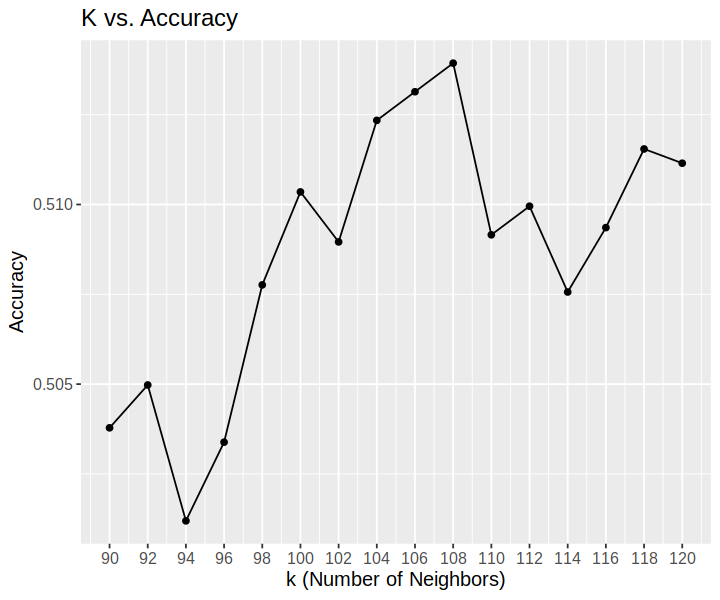

In [16]:
#1.6
k_vals_health <- tibble(neighbors = seq(90,120, by=2))
#1.7
accurasies_health <- health_workflow |>
    tune_grid (resamples = health_vfold, grid = k_vals_health) |>
    collect_metrics() |>
  filter(.metric == "accuracy")
accurasies_health
#1.8
cross_val_plot_health <- accurasies_health |>
    ggplot(aes (x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs (x = "k (Number of Neighbors)",
          y = "Accuracy",
         title = "K vs. Accuracy") +
      theme(text = element_text(size = 12))+
scale_x_continuous(breaks = seq(90, 120, by = 2)) # adjusting the x-axis
cross_val_plot_health

##### 1.9 As shown in the `K`Vs.`accuracy` plot, the best $K$ is $K$=108

## 2. Now that we have obtained our best `K`, we will perform `knn` on our training data with this value of `k`
##### 2.1. Create a new `knn` `model`, using the appropriate engine and mode and set `neighbors = 76` as we obtained in the cross-validation.
##### 2.2. Fit the `recipe` we made previously called`demographics_recipe`and new `model` into the `workflow`.
##### 2.3. Use the function `predict` to apply the prediction on our testing data `stroke_test_demographics`.
##### 2.4. Finally we report the accuracy of this prediction and will store this number to compare to accuracy of our `lifestyle` and `health factors` models.

In [17]:
#2.1 
health_final_spec <- nearest_neighbor (weight_func = "rectangular", neighbors = 108)|>
    set_engine("kknn") |>
    set_mode("classification")
health_final_spec

#2.2
health_final_workflow <- workflow() |>
    add_recipe (health_recipe)|>
    add_model (health_final_spec)|>
    fit(data= stroke_train_health)
health_final_workflow

2.3
health_prediction <- predict(health_final_workflow, stroke_test_health)|>
    bind_cols (stroke_test_health)
health_prediction

2.4
health_accuracy <- health_prediction |>
  metrics(truth = diagnosis, estimate = .pred_class) |>
  filter(.metric == "accuracy")
health_accuracy

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 108
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(108,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4767118
Best kernel: rectangular
Best k: 108

[1] 2.3

.pred_class,diagnosis,hypertension,heart_disease,stress
<fct>,<fct>,<dbl>,<dbl>,<dbl>
No Stroke,Stroke,1,1,6.84
No Stroke,No Stroke,1,0,6.38
No Stroke,Stroke,0,1,2.58
⋮,⋮,⋮,⋮,⋮
No Stroke,No Stroke,1,1,7.87
No Stroke,No Stroke,0,0,7.59
No Stroke,No Stroke,0,0,1.47


[1] 2.4

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5145396


## Health KNN Classification Accuracy = 0.5145396

# Choose the best predictor set
## Now we are done doing the classification of all three prediction factors of Demographics, Lifestyle, and Health, we will compare their accuracies:
## Health factors = 0.5145396 > Demographics factors =  0.5117124 > Lifestyle factors = 0.5016155
### Thus, we conclude that Health factors are the most accurate predictors among our choices

<img src="https://vitals.sutterhealth.org/files/2020/05/iStock-1168179082.jpg" width = "600"/>

### As for the extention of our project, we will now use all three models we have made to determine the stroke status of our random patient based on their profile:
#### we asked R to create our random patient using the functions `sample`, `runif`, and `generate_random_profile()`

In [27]:
generate_random_profile <- function() {
  profile <- tibble(
    age = sample(1:98, 1),
    gender = sample(0:1, 1),
    hypertension = sample(0:1, 1),
    heart_disease = sample(0:1, 1),
    alcohol_intake = sample(0:3, 1),
    activity = sample(1:3, 1),
    family_history = sample(0:1, 1),
    diet = sample(1:7, 1),
    stress = runif(1, 0, 9)
  )
  return(profile)
}
random_patient_profile <- generate_random_profile()
random_patient_profile

age,gender,hypertension,heart_disease,alcohol_intake,activity,family_history,diet,stress
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
40,1,1,1,2,2,1,5,8.654157


#### Here is our patient Hiva, according to the random patient generator:
Hiiva is a 40 years old female, who has had hypertension before. Hiva ....
#### Here is Hiva's image below

## Expected Results:
In this data analysis project, having 3 categories to be potentially used for the prediction of a patient's stroke status, we aim to find the best knn model between them. with the 3 categories being demographics, health, and lifestyle, we predict that the health category involving hypertension, heart disease and stress level predictors will have the highest accuracy to be used as a prediction model to find out a patient's stroke history status. 

## We do this because ...
The findings of the data study will benefit clinical, public and personal health. Knowing the most impactful factors, healthcare professionals can determine if someone is at a higher risk of having a stroke by putting more focus on those factors. Depending on the outcome of our study, people can improve their lifestyle habits and take preventive measures to reduce their risks of getting a stroke.

## But what about...
Future questions:
* Are there other demographic, health, or lifestyle factors that were not considered in this study but might also influence stroke risk?
* Can predictive models be developed to estimate an individual's stroke risk more accurately based on multiple risk factors?
* What are the long-term effects of interventions aimed at reducing stroke risk?

<img src="https://media.giphy.com/media/3orieTTZVPaVNMhRra/giphy.gif" width = "600"/>

## Sources
* Dataset: https://www.kaggle.com/datasets/teamincribo/stroke-prediction/data
* Gif: https://media.giphy.com/media/3orieTTZVPaVNMhRra/giphy.gif
* Stroke Image: https://vitals.sutterhealth.org/files/2020/05/iStock-1168179082.jpg
* Stroke background information: https://www.cdc.gov/stroke/about.htm#:~:text=A%20stroke%2C%20sometimes%20called%20a,term%20disability%2C%20or%20even%20death.

In [19]:
#### This is the main data file (to be handed in)#####

# Please read the following before adding changes to this document:
# 1. Does the code you are running work? (Have you run the code in your personal draft file and it returns no error?)
# 2. Have you consulted in the group chat before committing your code?
# 3. Be sure to add a comment for what the code added is for, and also your initials, so we can track changes!
# 4. Commit often so that we can see the history of changes.
# 5. Before pushing your changes to GitHub, remember that all changes will override the final file.

# Example below - Ching has added the data file.